# Example Usage

This is a basic example using the torchvision COCO dataset from coco.py, it assumes that you've already downloaded the COCO images and annotations JSON.  You'll notice that the scale augmentations are quite extreme.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import cv2
import numpy as np
import albumentations as A
import random
from matplotlib import pyplot as plt

from copy_paste import CopyPaste

from coco import download_dataset
from coco import CocoDetectionCP

from visualize import display_instances

In [4]:
# download the training set from COCO 2014
# It must be the training set because we need to use the annotations

# Path to the COCO dataset directory
base_dir = '../datasets/coco/'
# data_dir, annot_dir = download_dataset(base_dir, dataset_name='train2014')
data_dir, annot_dir = base_dir + "train2014", base_dir + "annotations"

In [5]:
transform = A.Compose([
        A.RandomScale(scale_limit=(-0.9, 1), p=1),  # LargeScaleJitter from scale of 0.1 to 2
        A.PadIfNeeded(256, 256, border_mode=0),  # pads with image in the center, not the top left like the paper
        A.RandomCrop(256, 256),
        CopyPaste(blend=True, sigma=1, pct_objects_paste=0.8, p=1.)  # pct_objects_paste is a guess
    ], bbox_params=A.BboxParams(format="coco", min_visibility=0.05)
)

data = CocoDetectionCP(
    data_dir,
    os.path.join(annot_dir, 'instances_train2014.json'),
    transform
)

loading annotations into memory...
Done (t=16.34s)
creating index...
index created!


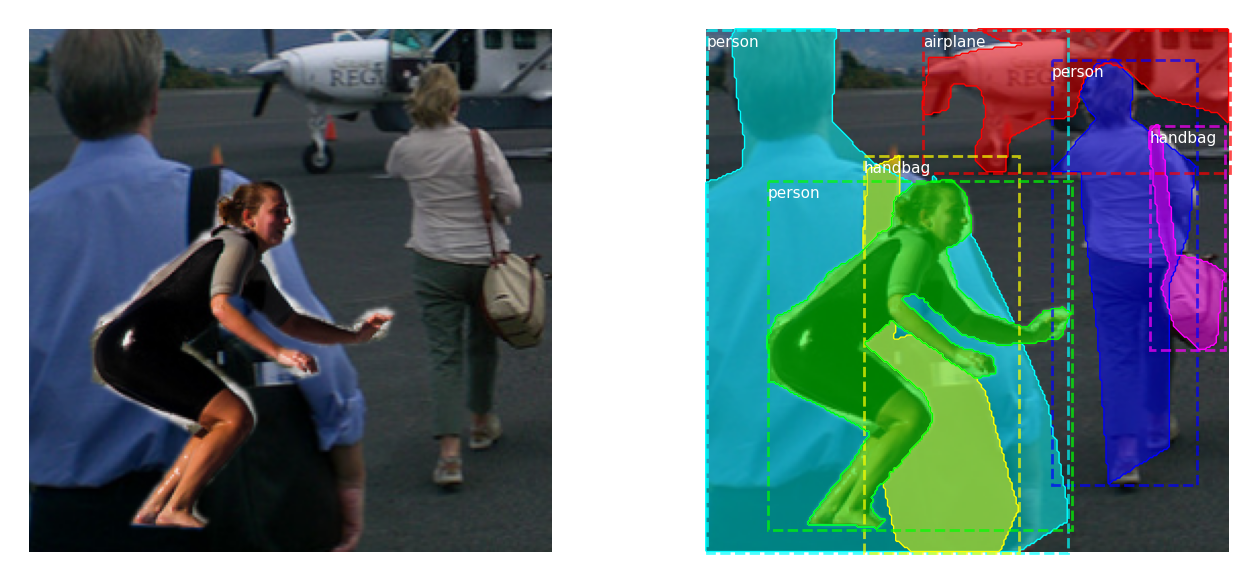

In [33]:
f, ax = plt.subplots(1, 2, figsize=(16, 16))

# index = random.randint(0, len(data))
index = 32335  # fix this index while debugging to see the same background image
img_data = data[index]
image = img_data['image']
masks = img_data['masks']
bboxes = img_data['bboxes']

empty = np.array([])
display_instances(image, empty, empty, empty, empty, show_mask=False, show_bbox=False, ax=ax[0])

if len(bboxes) > 0:
    boxes = np.stack([b[:4] for b in bboxes], axis=0)
    box_classes = np.array([b[-2] for b in bboxes])
    mask_indices = np.array([int(b[-1]) for b in bboxes])
    show_masks = np.stack(masks, axis=-1)[..., mask_indices]
    class_names = {k: data.coco.cats[k]['name'] for k in data.coco.cats.keys()}
    display_instances(image, boxes, show_masks, box_classes, class_names, show_bbox=True, ax=ax[1])
else:
    display_instances(image, empty, empty, empty, empty, show_mask=False, show_bbox=False, ax=ax[1])